# Exploring Different Neural Network Architectures with MNIST
In this comprehensive notebook, we embark on a journey to explore and compare different neural network architectures using the classic MNIST dataset, a collection of handwritten digits. We start by examining a Convolutional Neural Network (CNN), known for its effectiveness in image recognition tasks. As we progress, we delve into the realm of transfer learning, adapting a pre-trained ResNet model to our dataset. This exploration provides insights into the strengths and specific applications of each architecture, from standard deep neural networks (DNNs) to advanced models trained on massive datasets. Our goal is to understand how each model learns to recognize handwritten digits, and to compare their performance in terms of accuracy, loss, and other key metrics. Whether you're a beginner or have some experience in deep learning, this notebook is designed to offer a practical, hands-on understanding of different neural network architectures.

## Importing Libraries and Loading Data
To get started, we first import the necessary libraries that will help us in data handling, visualization, and neural network construction. We then load the MNIST dataset, a popular dataset of handwritten digits, and prepare it for training. Additionally, we define a function to display images from the dataset, which helps us visually verify the data we're working with. Let's see some examples of the MNIST images.

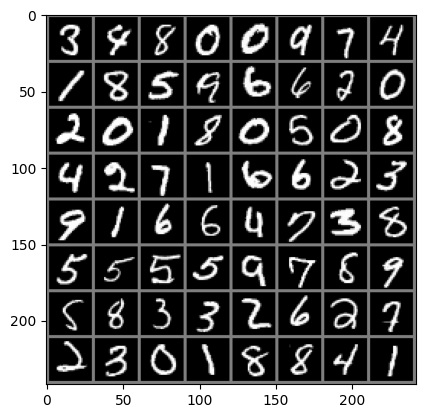

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split

# Transformation for the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Load MNIST training dataset
full_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Splitting the full training dataset into train and validation sets
train_proportion = 0.8 # 80% of the full training dataset for training, remaining 20% for validation
train_size = int(train_proportion * len(full_trainset))
validation_size = len(full_trainset) - train_size
trainset, validateset = random_split(full_trainset, [train_size, validation_size])

# Creating data loaders for the train and validation sets
BATCH_SIZE = 64
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validateloader = DataLoader(validateset, batch_size=BATCH_SIZE, shuffle=True)

# Load the test dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

# Function to show images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

## Defining the Training Function
Training a neural network involves several steps repeated over multiple iterations or epochs. To make our code clean and reusable, we define a `train_model` function. This function takes a neural network model, training and validation data loaders, a loss function, and an optimizer, and then performs the training process. It also implements early stopping to prevent overfitting.

In [2]:
def train_model(model, trainloader, validateloader, criterion, optimizer, num_epochs=10, patience=3, device='cuda'):
    best_loss = float('inf')
    epochs_no_improve = 0

    train_loss_list, validation_loss_list = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss_list.append(running_loss / len(trainloader))

        # Validation loss
        model.eval()
        validation_loss = 0.0
        with torch.no_grad():
            for data in validateloader:
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()

        validation_loss_list.append(validation_loss / len(validateloader))

        # Early stopping
        if validation_loss < best_loss:
            best_loss = validation_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f'Early stopping triggered after {epoch + 1} epochs')
            break

        print(f'Epoch {epoch + 1}, Training Loss: {running_loss / len(trainloader)}, Validation Loss: {validation_loss / len(validateloader)}')

    print('Finished Training')
    return train_loss_list, validation_loss_list

## Visualizing Training and Validation Loss
Tracking the training progress is crucial to understand how well our model is learning. This section introduces a function to plot the training and validation loss curves. These plots will help us visualize the model's learning behavior over epochs and adjust our training strategy if needed.

In [3]:
import matplotlib.pyplot as plt

def plot_train_val_loss(train_loss, val_loss):
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curve')
    plt.xticks(range(len(train_loss)), range(1, len(train_loss) + 1))  # Setting x-axis ticks to represent integer epochs
    plt.legend()
    plt.show()

## Defining the Evaluation Function
After training the model, we need to evaluate its performance on unseen data. In this section, we define an `evaluate_model` function that calculates various metrics such as accuracy, precision, recall, and F1 score on the test dataset. These metrics give us insights into the model's generalization capability.

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(model, testloader, device='cuda'):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    return accuracy, precision, recall, f1, conf_matrix

## Convolutional Neural Network (CNN)
Now, we define the architecture of our CNN. This section explains the structure of the CNN used for image classification on the MNIST dataset. We'll go through each layer of the network and understand its purpose and function.

### Architecture Definition

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Define a CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### Training
With our CNN architecture defined, it's time to train the network. We set up the loss function and optimizer, which are key components of the training process. Then, we use our previously defined `train_model` function to train the CNN on the MNIST dataset. During training, we'll also visualize the loss curve to monitor the model's learning progress.

Using device: cuda:0
Epoch 1, Training Loss: 2.2551720107396442, Validation Loss: 2.0082975055309054
Epoch 2, Training Loss: 0.6753176195720831, Validation Loss: 0.2556372613428121
Epoch 3, Training Loss: 0.20518806587656338, Validation Loss: 0.17019290112434549
Finished Training


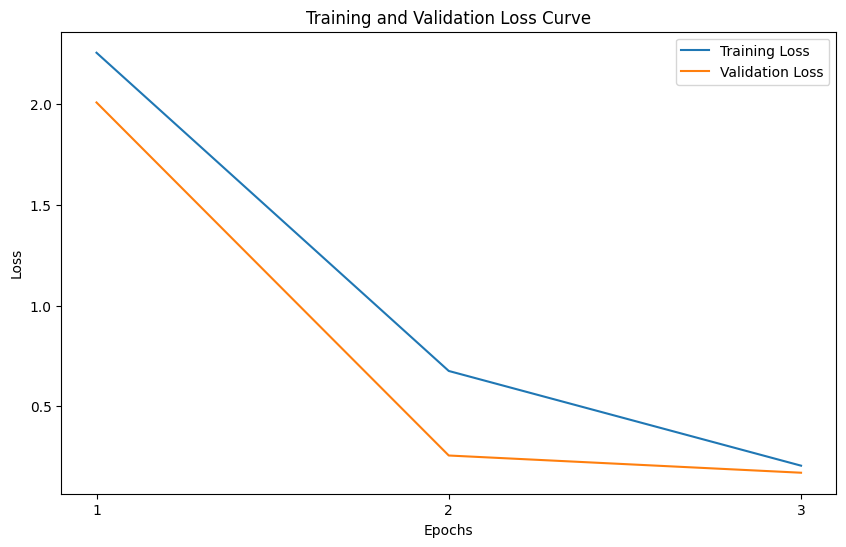

In [6]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the cnnwork
cnn = CNN().to(device)

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

# Train the model
train_loss_cnn, val_loss_cnn = train_model(cnn, trainloader, validateloader, criterion, optimizer, num_epochs=3, patience=3, device=device)
plot_train_val_loss(train_loss=train_loss_cnn, val_loss=val_loss_cnn)


### Evalutation
After training, the next step is to evaluate the model's performance on the test dataset. In this final section, we use the `evaluate_model` function to test the CNN and calculate performance metrics.

In [7]:
# Put the network on the device
cnn.to(device)

accuracy_cnn, precision_cnn, recall_cnn, f1_cnn, conf_matrix_cnn = evaluate_model(cnn, testloader, device=device)

print(f'Accuracy: {accuracy_cnn:.4f}')
print(f'Precision: {precision_cnn:.4f}')
print(f'Recall: {recall_cnn:.4f}')
print(f'F1 Score: {f1_cnn:.4f}')
print('Confusion Matrix:\n', conf_matrix_cnn)

Accuracy: 0.9528
Precision: 0.9532
Recall: 0.9528
F1 Score: 0.9527
Confusion Matrix:
 [[ 972    0    1    0    0    1    3    1    2    0]
 [   0 1121    4    2    0    1    2    1    4    0]
 [  17    3  958   19    4    0    4   17    9    1]
 [   1    0    5  982    0    9    0    9    4    0]
 [   2    2    2    0  938    0    9    4    3   22]
 [  11    0    1   23    0  844    3    3    6    1]
 [  17    3    3    0    9    8  913    0    5    0]
 [   2    9   16    5    1    2    0  981    3    9]
 [  14    2    4   14    2    6    3   14  906    9]
 [  10    6    6    7   14    9    0   35    9  913]]


## Deep Neural Network (DNN)
After exploring the CNN, let's introduce another architecture - a Deep Neural Network (DNN). Unlike CNNs, DNNs consist of fully connected layers and do not utilize convolutional or pooling layers. This section will define a DNN model suited for the MNIST dataset, train it, and compare its performance with the CNN.

### Architecture Definition
Here we define the architecture of our DNN. The DNN will have multiple fully connected layers, each followed by a non-linear activation function. This architecture aims to learn features from the flattened MNIST images and classify them into the correct digit categories.

In [8]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)  # MNIST images are 28x28 pixels
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)      # 10 output classes for MNIST digits

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the images
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)        # No activation in the last layer (logits)
        return x

dnn = DNN().to(device)

### Training
Now, we'll train the DNN using the same training function we used for the CNN. We will also use the same dataset, loss function, and optimizer settings to ensure a fair comparison between the two models.

Epoch 1, Training Loss: 2.1889931319554647, Validation Loss: 1.6886702528659334
Epoch 2, Training Loss: 0.8891769284009934, Validation Loss: 0.5959743676667518
Epoch 3, Training Loss: 0.48463679498434065, Validation Loss: 0.41361600128894155
Finished Training


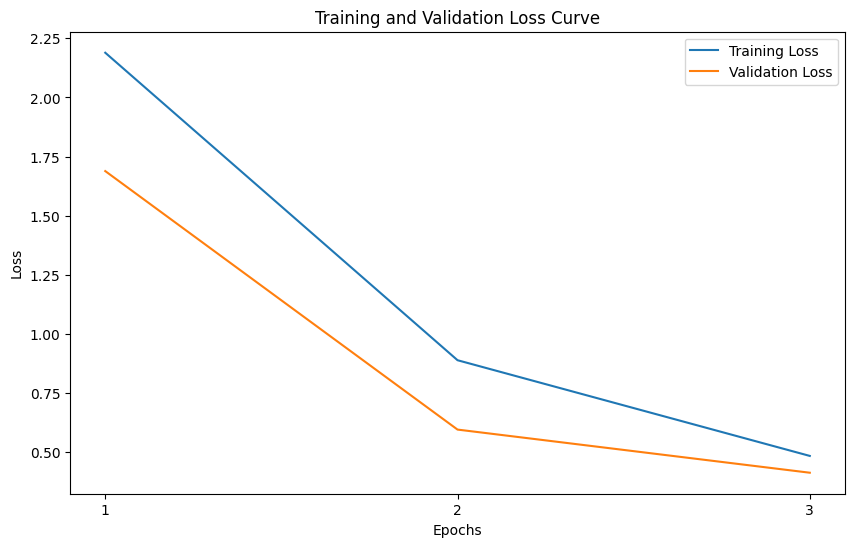

In [9]:
optimizer_dnn = optim.SGD(dnn.parameters(), lr=0.001, momentum=0.9)
train_loss_dnn, val_loss_dnn = train_model(dnn, trainloader, validateloader, criterion, optimizer_dnn, num_epochs=3, patience=3, device=device)
plot_train_val_loss(train_loss=train_loss_dnn, val_loss=val_loss_dnn)

### Evalutation
With the DNN trained, we now evaluate its performance on the test set using the same evaluation function. This will allow us to compare its effectiveness in classifying MNIST digits against the CNN's performance.

In [10]:
accuracy_dnn, precision_dnn, recall_dnn, f1_dnn, conf_matrix_dnn = evaluate_model(dnn, testloader, device=device)
print(f'Accuracy: {accuracy_dnn:.4f}')
print(f'Precision: {precision_dnn:.4f}')
print(f'Recall: {recall_dnn:.4f}')
print(f'F1 Score: {f1_dnn:.4f}')
print('Confusion Matrix:\n', conf_matrix_dnn)

Accuracy: 0.8815
Precision: 0.8828
Recall: 0.8815
F1 Score: 0.8814
Confusion Matrix:
 [[ 933    0    1    1    2   37    4    1    1    0]
 [   0 1105    2    7    0    1    3    1   15    1]
 [  11   34  839   39   17    9   24   10   41    8]
 [   1    5   25  858    0   68    0   20   26    7]
 [   1    6    3    0  881    4   15    2    8   62]
 [   9    3    8   56   10  752   18    9   20    7]
 [  11    3    7    0   14   29  891    0    3    0]
 [   4   34   12    3    6    3    0  915    9   42]
 [   4   13    8   24   19   61   15    6  792   32]
 [   9    2    1    6   69   20    1   43    9  849]]


## Transfer Learning with a Pre-Trained Model
In this section, we explore the concept of transfer learning, a powerful technique in deep learning where we leverage a pre-trained model and adapt it to our specific task. We'll start by loading a pre-trained ResNet model and modifying it for our MNIST dataset, which consists of grayscale images. This approach allows us to utilize the rich feature extraction capabilities of ResNet, trained on a large and diverse dataset, and apply it to handwritten digit recognition.

### Modifying the Pre-Trained Model for MNIST
First, we define our model architecture. We'll begin with the ResNet model, pre-trained on the ImageNet dataset. Since MNIST images are grayscale and have different dimensions compared to ImageNet images, we need to adjust the first convolutional layer to handle single-channel (grayscale) inputs. Additionally, the final fully connected layer is modified to output 10 classes, corresponding to the ten digits in MNIST.

In [11]:
from torchvision import models
from torchvision.models import ResNet18_Weights
import torch.nn as nn

# Load a pre-trained ResNet model with the new 'weights' parameter
resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Modify the model to fit MNIST (grayscale images)
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Adjust for grayscale
resnet.fc = nn.Linear(resnet.fc.in_features, 10)  # Adjust for 10 classes of MNIST

# Move the model to the correct device (GPU or CPU)
resnet = resnet.to(device)

# Freeze the weights
for param in resnet.parameters():
    param.requires_grad = False

# Unfreeze some layers for fine-tuning
for param in resnet.layer4.parameters():
    param.requires_grad = True

### Training the Adapted Model
After modifying the model, the next step is to train it on the MNIST dataset. This process involves fine-tuning some layers of the model while keeping others frozen. By doing so, we can retain the general feature-detecting capabilities of the pre-trained model while adapting it to recognize handwritten digits. We will use the same training loop as before but with the adapted ResNet model.


Epoch 1, Training Loss: 0.5548496957222621, Validation Loss: 0.3480841133426479
Epoch 2, Training Loss: 0.30414235531290373, Validation Loss: 0.2869412355283473
Epoch 3, Training Loss: 0.22989374053974945, Validation Loss: 0.2867540298227934
Finished Training


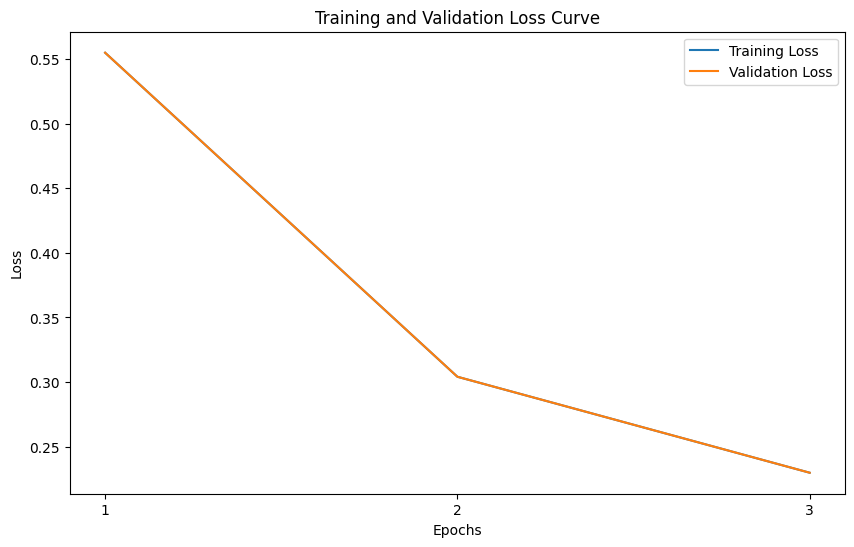

In [12]:
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_loss_resnet, val_loss_resnet = train_model(resnet, trainloader, validateloader, criterion, optimizer, num_epochs=3, device=device)
plot_train_val_loss(train_loss=train_loss_resnet, val_loss=train_loss_resnet)

### Evaluating the Performance on MNIST
Once training is complete, we evaluate our adapted model on the MNIST test set. This step is crucial to understand how well the transfer learning approach has worked for digit recognition. We'll use the same evaluation metrics as before, like accuracy and loss, to assess the model's performance and compare it with our previous models.


In [13]:
accuracy_resnet, precision_resnet, recall_resnet, f1_resnet, conf_matrix_resnet = evaluate_model(resnet, testloader, device=device)
print(f'Accuracy: {accuracy_resnet:.4f}')
print(f'Precision: {precision_resnet:.4f}')
print(f'Recall: {recall_resnet:.4f}')
print(f'F1 Score: {f1_resnet:.4f}')
print('Confusion Matrix:\n', conf_matrix_resnet)

Accuracy: 0.9144
Precision: 0.9156
Recall: 0.9144
F1 Score: 0.9146
Confusion Matrix:
 [[ 936    0    6    2    1    9    7    2   13    4]
 [   1 1104    7    2    1    4    8    2    3    3]
 [  12    0  942   33    2    6    6    7   22    2]
 [   2    0   21  926    2   32    0    7   16    4]
 [   3    2    7    2  873    5   11    7   11   61]
 [   3    0    7   36    4  801    9    1   19   12]
 [   9    2    7    1   11    9  915    0    3    1]
 [   0    2   15   28   13    7    0  897    5   61]
 [   7    0   16   31    5   30   10    5  858   12]
 [   8    4    3   19   34    9    0   16   24  892]]
